# TRANSFORMACIÓN DE DATOS

## IMPORTAR PAQUETES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

1.- Sustituir la ruta del proyecto.

In [2]:
ruta_proyecto = 'C:/Users/Oscar/OneDrive - FM4/Escritorio/Python Data Mastery/EstructuraDirectorio/03_MACHINE_LEARNING/08_CASOS/003_RIESGOS'

2.- Nombrar los ficheros de datos.

In [3]:
nombre_cat = 'cat_resultado_eda.pickle'
nombre_num = 'num_resultado_eda.pickle'

3.- Cargar los datos.

In [4]:
cat = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_cat)
num = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_num)

Recordamos lo que habíamos identificado en fases anteriores y lo organizamos por tipo de acción.

Modificar con pandas/numpy:

* Crear la target a partir de estado
* Discretizar num_meses_desde_ult_retraso
* En vivienda juntar NONE y OTHER
* En finalidad juntar renewable_energy, educational y vacation en 'otros'

Modificar con scikit learn:

* La variable descripcion podríamos trabajarla con un TF-IDF Vectorizer
* Convertir num_derogatorios a binaria

## CREACIÓN DE VARIABLES Y TRANSFORMACIONES CON PANDAS

### Target para el modelo Probability of Default (Probabilidad de generar un impago)

'>90 días sin pagar la cuota'

Crear la target a partir de estado donde 1 serán los clientes con impagos (los malos) y 0 los que están al corriente de pago (los buenos)

En este paso debemos decidir cuales son los que deben 0 y 1 y dependerá del criterio que decidamos aplicarle

In [5]:
cat.estado.value_counts()

estado
Fully Paid                                             66243
Current                                                54083
Charged Off                                            16430
Late (31-120 days)                                      1321
In Grace Period                                          540
Late (16-30 days)                                        263
Does not meet the credit policy. Status:Fully Paid       122
Does not meet the credit policy. Status:Charged Off       52
Default                                                    3
Name: count, dtype: int64

In [6]:
#Metemos en la variable los estados que consideramos que tienen impagos
cat['target_pd'] = np.where(cat.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
cat

,empleo,antiguedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,cat_tarjetas_75p,target_pd
id_cliente,,,,,,,,,,,
4798121,"Target Promotions and Marketing,Inc",10+ years,Not Verified,D,RENT,desconocido,debt_consolidation,36 months,Charged Off,>75%,1
46641215,Banker,5 years,Verified,A,RENT,desconocido,debt_consolidation,36 months,Fully Paid,<10%,0
87998444,executive director,9 years,Source Verified,B,MORTGAGE,desconocido,credit_card,60 months,Current,<10%,0
132883631,Subsea Technician,7 years,Source Verified,B,MORTGAGE,desconocido,debt_consolidation,36 months,Fully Paid,11-75%,0
77861711,Correctional officer,10+ years,Verified,C,MORTGAGE,desconocido,debt_consolidation,36 months,Charged Off,<10%,1
...,...,...,...,...,...,...,...,...,...,...,...
73222117,Executive Assistant,10+ years,Verified,B,RENT,desconocido,debt_consolidation,36 months,Fully Paid,>75%,0
119242742,desconocido,desconocido,Source Verified,C,RENT,desconocido,debt_consolidation,36 months,Late (31-120 days),11-75%,0
51876926,Office Manager,10+ years,Not Verified,C,MORTGAGE,desconocido,debt_consolidation,36 months,Fully Paid,>75%,0


In [7]:
cat.drop(columns='estado',inplace=True)

### Target para el modelo Exposure At Default (Cuanto se debe del préstamo en el momento del impago) 

Será el porcentaje del principal que no había sido amortizado y lo calculamos en dos pasos:

* Primero tenemos que saber cual es la suma pendiente del prestamo: principal - amortizado
* Después lo haremos sacamos su %: pendiente / principal

In [8]:
num['pendiente'] = num.principal - num.imp_amortizado
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,num_meses_desde_ult_retraso,pendiente
id_cliente,,,,,,,,,,,,,,,
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,0.0,3637.04
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,999.0,0.00
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,999.0,14557.00
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,22000.0,10.90,719.22,22000.00,0.00,16.0,0.00
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,14400.0,15.31,501.37,2310.49,6430.36,8.0,12089.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,3000.0,9.75,96.45,3000.00,0.00,999.0,0.00
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,999.0,1503.94
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,8000.0,12.29,266.83,8000.00,0.00,13.0,0.00


In [9]:
#Realizamos la variable en %. Hace que sea aplicable a cualquier préstamo porque nos dirá el % en el que habrá un impago
num['target_ead'] = num.pendiente / num.principal
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,num_meses_desde_ult_retraso,pendiente,target_ead
id_cliente,,,,,,,,,,,,,,,,
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,0.0,3637.04,0.363704
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,999.0,0.00,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,999.0,14557.00,0.539148
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,22000.0,10.90,719.22,22000.00,0.00,16.0,0.00,0.000000
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,14400.0,15.31,501.37,2310.49,6430.36,8.0,12089.51,0.839549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,3000.0,9.75,96.45,3000.00,0.00,999.0,0.00,0.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,999.0,1503.94,0.601576
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,8000.0,12.29,266.83,8000.00,0.00,13.0,0.00,0.000000


### Target para el modelo LGD

Será el porcentaje del pendiente que NO se recupera en caso de impago después de hacer las acciones necesarias

Por tanto: 1 - (imp_recuperado / pendiente)

In [10]:
num['target_lgd'] = 1 - (num.imp_recuperado / num.pendiente)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,num_meses_desde_ult_retraso,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,0.0,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,999.0,0.00,0.000000,NaN
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,999.0,14557.00,0.539148,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,22000.0,10.90,719.22,22000.00,0.00,16.0,0.00,0.000000,NaN
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,14400.0,15.31,501.37,2310.49,6430.36,8.0,12089.51,0.839549,0.468104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,3000.0,9.75,96.45,3000.00,0.00,999.0,0.00,0.000000,NaN
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,999.0,1503.94,0.601576,1.000000
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,8000.0,12.29,266.83,8000.00,0.00,13.0,0.00,0.000000,NaN


Los nulos se producen cuando el pendiente es cero. Por tanto podemos imputarlos por ceros.

In [11]:
#num.imp_recuperado / num.pendiente puede ser NaN porque sea 0/0. Para esos casos rellenamos con 0 los nulos 
num['target_lgd'] = num['target_lgd'].fillna(0)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,num_meses_desde_ult_retraso,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,0.0,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,999.0,0.00,0.000000,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,999.0,14557.00,0.539148,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,22000.0,10.90,719.22,22000.00,0.00,16.0,0.00,0.000000,0.000000
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,14400.0,15.31,501.37,2310.49,6430.36,8.0,12089.51,0.839549,0.468104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,3000.0,9.75,96.45,3000.00,0.00,999.0,0.00,0.000000,0.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,999.0,1503.94,0.601576,1.000000
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,8000.0,12.29,266.83,8000.00,0.00,13.0,0.00,0.000000,0.000000


Comprobamos las targets creadas.

In [12]:
cat['target_pd'].mean()

0.11854850888484578

In [13]:
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,num_meses_desde_ult_retraso,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,0.0,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,999.0,0.00,0.000000,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,999.0,14557.00,0.539148,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,22000.0,10.90,719.22,22000.00,0.00,16.0,0.00,0.000000,0.000000
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,14400.0,15.31,501.37,2310.49,6430.36,8.0,12089.51,0.839549,0.468104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,3000.0,9.75,96.45,3000.00,0.00,999.0,0.00,0.000000,0.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,999.0,1503.94,0.601576,1.000000
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,8000.0,12.29,266.83,8000.00,0.00,13.0,0.00,0.000000,0.000000


In [14]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139057.0,0.337659,0.369411,-0.000012,0.0,0.128781,0.726121,1.0
target_lgd,139057.0,0.508519,0.490403,-0.264347,0.0,0.850313,1.000000,1.0


Limitamos para garantizar que siempre estén entre 0 y 1

In [15]:
num.target_ead = np.where(num.target_ead < 0, 0, num.target_ead)
num.target_ead = np.where(num.target_ead > 1, 1, num.target_ead)
num.target_lgd = np.where(num.target_lgd < 0, 0, num.target_lgd)
num.target_lgd = np.where(num.target_lgd > 1, 1, num.target_lgd)

In [16]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139057.0,0.337659,0.369411,0.0,0.0,0.128781,0.726121,1.0
target_lgd,139057.0,0.508549,0.490368,0.0,0.0,0.850313,1.000000,1.0


### Resto de variables

num_meses_desde_ult_retraso

Vamos a comenzar revisando la relación con la target_pd

In [17]:
temp = num[['num_meses_desde_ult_retraso']].copy()

In [18]:
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp['num_meses_desde_ult_retraso'],20)
temp['target'] = cat['target_pd']
temp

,num_meses_desde_ult_retraso,num_meses_desde_ult_retraso_tramos,target
id_cliente,,,
4798121,0.0,"(-0.999, 49.95]",1
46641215,999.0,"(949.05, 999.0]",0
87998444,999.0,"(949.05, 999.0]",0
132883631,16.0,"(-0.999, 49.95]",0
77861711,8.0,"(-0.999, 49.95]",1
...,...,...,...
73222117,999.0,"(949.05, 999.0]",0
119242742,999.0,"(949.05, 999.0]",0
51876926,13.0,"(-0.999, 49.95]",0


In [19]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean()

C:\Users\Oscar\AppData\Local\Temp\ipykernel_1640\2104936897.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean()


num_meses_desde_ult_retraso_tramos
(-0.999, 49.95]    0.246494
(49.95, 99.9]      0.119852
(99.9, 149.85]     0.137255
(149.85, 199.8]    0.333333
(199.8, 249.75]         NaN
(249.75, 299.7]         NaN
(299.7, 349.65]         NaN
(349.65, 399.6]         NaN
(399.6, 449.55]         NaN
(449.55, 499.5]         NaN
(499.5, 549.45]         NaN
(549.45, 599.4]         NaN
(599.4, 649.35]         NaN
(649.35, 699.3]         NaN
(699.3, 749.25]         NaN
(749.25, 799.2]         NaN
(799.2, 849.15]         NaN
(849.15, 899.1]         NaN
(899.1, 949.05]         NaN
(949.05, 999.0]    0.000000
Name: target, dtype: float64

C:\Users\Oscar\AppData\Local\Temp\ipykernel_1640\1656090056.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();


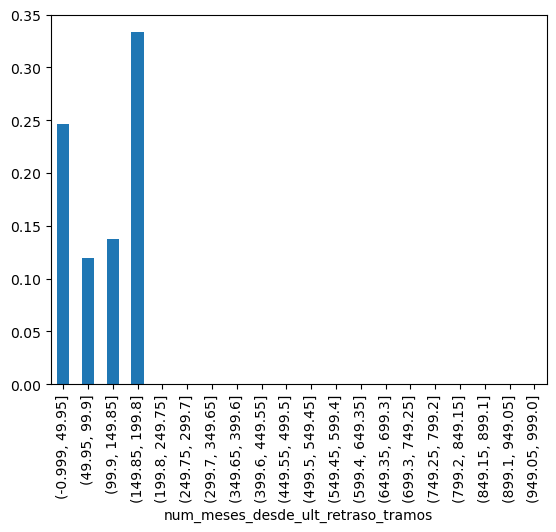

In [20]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

In [21]:
num.loc[(num.num_meses_desde_ult_retraso>=175)&(num.num_meses_desde_ult_retraso<=186)]

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,num_meses_desde_ult_retraso,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
16130949,55000.0,10.54,1.0,8.0,0.0,14.2,0.0,2.0,10000.0,11.67,330.57,9672.65,0.0,180.0,327.35,0.032735,1.0


ISAAC: La distribución de la target en esta variable no nos genera confianza, así que la descartamos.

OSCAR: Yo no voy a eliminar la variable porque creo que Isaac no le está dando el sentido adecuado a la variable y si que tiene sentido. 

Después de haber puesto los nulos como 0 en num_meses_desde_ult_retraso para las categorías que hemos considerado como impagos, nos sale una gráfica mas lógica donde los del primer tramo contienen los impagos que hemos definido y el resto contienen la media de impagos y el tramo extraño es un solo dato que es el que vamos a eliminar porque no tiene sentido que un cliente a falta de pagar 337€ de 10000€ deje de pagar la última cuota, así que entendemos que es un error, lo borramos y volvemos a hacer el mismo análisis anterior con la tabla temporal para comprobar los resultados

In [22]:
num = num.drop(index=16130949)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,num_meses_desde_ult_retraso,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
4798121,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,10000.0,17.77,360.38,6362.96,0.00,0.0,3637.04,0.363704,1.000000
46641215,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,0.0,24000.0,6.39,734.38,24000.00,0.00,999.0,0.00,0.000000,0.000000
87998444,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,0.0,27000.0,8.99,560.35,12443.00,0.00,999.0,14557.00,0.539148,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,22000.0,10.90,719.22,22000.00,0.00,16.0,0.00,0.000000,0.000000
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,14400.0,15.31,501.37,2310.49,6430.36,8.0,12089.51,0.839549,0.468104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,3000.0,9.75,96.45,3000.00,0.00,999.0,0.00,0.000000,0.000000
119242742,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,0.0,2500.0,12.62,83.78,996.06,0.00,999.0,1503.94,0.601576,1.000000
51876926,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,0.0,8000.0,12.29,266.83,8000.00,0.00,13.0,0.00,0.000000,0.000000


In [23]:
temp = num.loc[temp['num_meses_desde_ult_retraso']<=900].copy()

In [24]:
temp = num[['num_meses_desde_ult_retraso']].copy()

In [25]:
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp['num_meses_desde_ult_retraso'],20)
temp['target'] = cat['target_pd']
temp

,num_meses_desde_ult_retraso,num_meses_desde_ult_retraso_tramos,target
id_cliente,,,
4798121,0.0,"(-0.999, 49.95]",1
46641215,999.0,"(949.05, 999.0]",0
87998444,999.0,"(949.05, 999.0]",0
132883631,16.0,"(-0.999, 49.95]",0
77861711,8.0,"(-0.999, 49.95]",1
...,...,...,...
73222117,999.0,"(949.05, 999.0]",0
119242742,999.0,"(949.05, 999.0]",0
51876926,13.0,"(-0.999, 49.95]",0


In [26]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean()

C:\Users\Oscar\AppData\Local\Temp\ipykernel_1640\2104936897.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean()


num_meses_desde_ult_retraso_tramos
(-0.999, 49.95]    0.246494
(49.95, 99.9]      0.119852
(99.9, 149.85]     0.137255
(149.85, 199.8]    0.000000
(199.8, 249.75]         NaN
(249.75, 299.7]         NaN
(299.7, 349.65]         NaN
(349.65, 399.6]         NaN
(399.6, 449.55]         NaN
(449.55, 499.5]         NaN
(499.5, 549.45]         NaN
(549.45, 599.4]         NaN
(599.4, 649.35]         NaN
(649.35, 699.3]         NaN
(699.3, 749.25]         NaN
(749.25, 799.2]         NaN
(799.2, 849.15]         NaN
(849.15, 899.1]         NaN
(899.1, 949.05]         NaN
(949.05, 999.0]    0.000000
Name: target, dtype: float64

C:\Users\Oscar\AppData\Local\Temp\ipykernel_1640\1656090056.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();


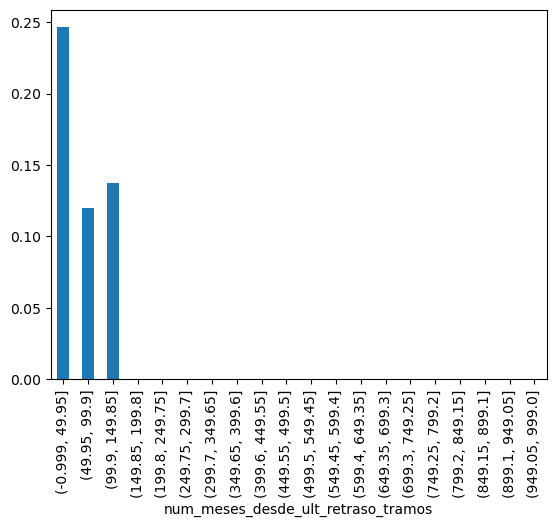

In [27]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

Tras hacer las comprobaciones sobre como se distribuyen los impagos, es posible que esta variable no tenga demasiada capacidad predictiva porque no se observan grandes diferencias pero la vamos a dejar por ver la evolución de mi análisis respecto al de Isaac

In [28]:
#En caso de querer borrar la variable
#num = num.drop(columns='num_meses_desde_ult_retraso')

En vivienda juntar ANY, NONE y OTHER

In [29]:
cat.vivienda.value_counts()

vivienda
MORTGAGE    68121
RENT        55373
OWN         15491
ANY            59
OTHER          10
NONE            3
Name: count, dtype: int64

In [30]:
cat.vivienda = cat.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')

In [31]:
cat.vivienda.value_counts()

vivienda
MORTGAGE    68193
RENT        55373
OWN         15491
Name: count, dtype: int64

En finalidad juntar renewable_energy, educational y wedding en 'otros'

In [32]:
cat.finalidad.value_counts()

finalidad
debt_consolidation    79011
credit_card           31292
home_improvement       9079
other                  8763
major_purchase         3115
medical                1645
small_business         1570
car                    1445
moving                 1011
vacation                990
house                   887
wedding                 139
renewable_energy         83
educational              27
Name: count, dtype: int64

In [33]:
cat.finalidad = cat.finalidad.replace(['wedding','educational','renewable_energy'],'otros')

In [34]:
cat.finalidad.value_counts()

finalidad
debt_consolidation    79011
credit_card           31292
home_improvement       9079
other                  8763
major_purchase         3115
medical                1645
small_business         1570
car                    1445
moving                 1011
vacation                990
house                   887
otros                   249
Name: count, dtype: int64

In [35]:
#Aquí empezamos a generar el excel de las transformaciones aunque no hayamos hecho preselección de variables, por lo que
#hay que pensar las transformaciones que le vamos a hacer a las variables sobre encoding, reescalado, etc porque las vamos
#a decidir nosotros

#Haremos OHE u OE según sea la variable y MMS según lo que hayamos hecho previamente. Es decir, las OE necesitan MMS y las
#numéricas también excepto las que vayamos a hacer binarización

#De cara a las variables que vayamos a pasar para realizar el modelo, debemos seleccionar las variables que vayamos a tener 
#disponibles en el futuro pool de variables que tendremos para realizar predicciones futuras. Ej: En modelos de Adquisición, 
#NO tendremos variables como la amortización anticipada que hace un cliente porque no tendremos histórico del cliente, si no
#que tenemos que usar variables que podamos conseguir en ese momento actual como: empleo, ingresos, cuotas, principa,...

#Modelos de ADQUISICIÓN: Son los que calculan el riesgo bancario sin el histórico y predicen en base a variables de ese momento
#Modelos de COMPORTAMIENTO: Son los que evaluan el histórico de actuaciones del cliente y predicen en función de ello

In [36]:
list(num.columns)

['ingresos',
 'dti',
 'num_hipotecas',
 'num_lineas_credito',
 'porc_tarjetas_75p',
 'porc_uso_revolving',
 'num_cancelaciones_12meses',
 'num_derogatorios',
 'principal',
 'tipo_interes',
 'imp_cuota',
 'imp_amortizado',
 'imp_recuperado',
 'num_meses_desde_ult_retraso',
 'pendiente',
 'target_ead',
 'target_lgd']

In [37]:
list(cat.columns)

['empleo',
 'antiguedad_empleo',
 'ingresos_verificados',
 'rating',
 'vivienda',
 'descripcion',
 'finalidad',
 'num_cuotas',
 'cat_tarjetas_75p',
 'target_pd']

In [38]:
cat.cat_tarjetas_75p.value_counts()

cat_tarjetas_75p
11-75%    67462
<10%      38210
>75%      33385
Name: count, dtype: int64

## TRANSFORMACIÓN DE CATEGÓRICAS

### One Hot Encoding

#### Variables a aplicar OHE

In [39]:
var_ohe = [ 'ingresos_verificados', 'vivienda','finalidad','num_cuotas']

#### Instanciar

In [40]:
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

#### Entrenar y aplicar

In [41]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

C:\Users\Oscar\miniconda3\envs\006_riesgos_gpt\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Guardar como dataframe

In [42]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

### Ordinal Encoding

#### Variables a aplicar OE

In [43]:
var_oe = ['antiguedad_empleo','rating','cat_tarjetas_75p']

#### Orden de los valores de las variables

In [44]:
#Orden de la primera variable
orden_antiguedad_empleo = ['desconocido','< 1 year','1 year','2 years','3 years','4 years',
                           '5 years','6 years','7 years','8 years','9 years','10+ years']

#Orden de la segunda variable
orden_rating = ['A','B','C','D','E','F','G']

#Orden de la tercera variable
orden_cat_tarjetas_75p = ['<10%','11-75%','>75%']

#### Instanciar

In [45]:
oe = OrdinalEncoder(categories = [orden_antiguedad_empleo,orden_rating,orden_cat_tarjetas_75p],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

#### Entrenar y aplicar

In [46]:
cat_oe = oe.fit_transform(cat[var_oe])

#### Guardar como dataframe

In [47]:
#Añadir sufijos a los nombres
nombres_oe = [variable + '_oe' for variable in var_oe]

#Guardar como dataframe
cat_oe = pd.DataFrame(cat_oe, columns = nombres_oe)

In [48]:
cat_oe

,antiguedad_empleo_oe,rating_oe,cat_tarjetas_75p_oe
0,11.0,3.0,2.0
1,6.0,0.0,0.0
2,10.0,1.0,0.0
3,8.0,1.0,1.0
4,11.0,2.0,0.0
...,...,...,...
139052,11.0,1.0,2.0
139053,0.0,2.0,1.0
139054,11.0,2.0,2.0
139055,11.0,3.0,1.0


### Fechas y textos

Cargamos stopwords y limpiamos

In [49]:
stop = pd.read_csv(ruta_proyecto + '/01_Documentos/stop_words_english.txt',names = ['termino'])

def quitar_tildes(palabra):
    #Definimos la versión con tildes y símbolos y la sin
    con = 'áéíóúüñÁÉÍÓÚÜÑ'
    sin = 'aeiouunAEIOUUN'
    #Creamos un traductor
    traductor = str.maketrans(con,sin)
    #Aplicamos el traductor y devolvemos la palabra limpia
    return(palabra.translate(traductor))

stop['limpias'] = stop.termino.transform(quitar_tildes)

Aplicamos tf-idf.

In [50]:
#Instanciamos
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     stop_words = stop.limpias.to_list(),
                     max_df = 0.7,
                     min_df = 50,
                     ngram_range = (1,3),
                     max_features = 50)

#Entrenamos y aplicamos
descripcion = tfidf.fit_transform(cat.descripcion)

C:\Users\Oscar\miniconda3\envs\006_riesgos_gpt\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [51]:
tfidf.vocabulary_

{'borrower': 15,
 '08': 7,
 '01': 0,
 '12': 11,
 'br': 22,
 '02': 1,
 'loan': 38,
 'borrower 08': 20,
 'br br': 24,
 'br borrower': 23,
 'br br borrower': 25,
 '07': 6,
 '13': 12,
 'consolidate': 29,
 'credit': 31,
 'card': 26,
 'years': 49,
 'borrower 07': 19,
 'credit card': 32,
 'bills': 14,
 'pay': 42,
 'payments': 46,
 'cards': 28,
 'monthly': 41,
 'paying': 44,
 'debt': 35,
 'rate': 47,
 'credit cards': 34,
 'borrower 12': 21,
 'time': 48,
 'payment': 45,
 '11': 10,
 '09': 8,
 'job': 37,
 '10': 9,
 'pay credit': 43,
 '05': 4,
 '06': 5,
 'consolidation': 30,
 'high': 36,
 'money': 39,
 'month': 40,
 'borrower 02': 17,
 '04': 3,
 '14': 13,
 '03': 2,
 'borrower 03': 18,
 'borrower 01': 16,
 'card debt': 27,
 'credit card debt': 33}

No parece que estos términos puedan generar información adicional a lo que tenemos, así que no incluiremos esta variable en los modelos.

## TRANSFORMACIÓN DE NUMÉRICAS

### Binarizar variables

#### Variables a binarizar

In [52]:
var_bin = ['num_derogatorios']

#### Instanciar

In [53]:
bin = Binarizer(threshold=0)

#### Entrenar y aplicar

In [54]:
num_bin = bin.fit_transform(num[var_bin])

#### Guardar como dataframe

In [55]:
#Añadir sufijos a los nombres
nombres_bin = [variable + '_bin' for variable in var_bin]

#Guardar como dataframe
num_bin = pd.DataFrame(num_bin,columns = nombres_bin)

## REESCALAR VARIABLES

### Con Min-Max

Unificar los datasets a reescalar.

In [56]:
list(num.columns)

['ingresos',
 'dti',
 'num_hipotecas',
 'num_lineas_credito',
 'porc_tarjetas_75p',
 'porc_uso_revolving',
 'num_cancelaciones_12meses',
 'num_derogatorios',
 'principal',
 'tipo_interes',
 'imp_cuota',
 'imp_amortizado',
 'imp_recuperado',
 'num_meses_desde_ult_retraso',
 'pendiente',
 'target_ead',
 'target_lgd']

In [57]:
num_escalar = num[['ingresos',
                   'dti',
                   'num_hipotecas',
                   'num_lineas_credito',
                   'porc_tarjetas_75p',
                   'porc_uso_revolving',
                   'num_cancelaciones_12meses',
                   'num_meses_desde_ult_retraso',
                   'principal',
                   'tipo_interes',
                   'imp_cuota']].reset_index(drop=True)

In [58]:
df_res = pd.concat([cat_oe,num_escalar], axis=1)

In [59]:
df_res

,antiguedad_empleo_oe,rating_oe,cat_tarjetas_75p_oe,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota
0,11.0,3.0,2.0,65000.0,25.40,1.0,15.0,85.7,86.2,0.0,0.0,10000.0,17.77,360.38
1,6.0,0.0,0.0,135000.0,14.68,0.0,19.0,0.0,16.3,0.0,999.0,24000.0,6.39,734.38
2,10.0,1.0,0.0,188000.0,11.69,3.0,15.0,0.0,3.3,0.0,999.0,27000.0,8.99,560.35
3,8.0,1.0,1.0,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,16.0,22000.0,10.90,719.22
4,11.0,2.0,0.0,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,8.0,14400.0,15.31,501.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139052,11.0,1.0,2.0,20000.0,8.02,0.0,5.0,66.7,33.2,0.0,999.0,2500.0,12.62,83.78
139053,0.0,2.0,1.0,42000.0,20.85,6.0,9.0,100.0,81.6,0.0,13.0,8000.0,12.29,266.83
139054,11.0,2.0,2.0,285000.0,6.02,3.0,9.0,25.0,21.1,0.0,25.0,30000.0,17.47,1076.62
139055,11.0,3.0,1.0,168000.0,4.69,0.0,8.0,0.0,52.4,0.0,0.0,30050.0,18.25,767.17


#### Variables a reescalar con Min-Max

In [60]:
var_mms = df_res.columns

#### Instanciar

In [61]:
mms = MinMaxScaler()

#### Entrenar y aplicar

In [62]:
df_mms = mms.fit_transform(df_res[var_mms])

#### Guardar como dataframe

In [63]:
#Añadir sufijos a los nombres
nombres_mms = [variable + '_mms' for variable in var_mms]

#Guardar como dataframe
df_mms = pd.DataFrame(df_mms,columns = nombres_mms)

## UNIFICAR DATASETS

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de PD

In [64]:
incluir_pd = [cat_ohe, cat_oe, df_mms, num_bin, cat.reset_index()[['id_cliente','target_pd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de PD

In [65]:
df_pd = pd.concat(incluir_pd, axis = 1)

In [66]:
df_pd.set_index('id_cliente',inplace=True)

In [67]:
list(df_pd.columns)

['ingresos_verificados_Not Verified',
 'ingresos_verificados_Source Verified',
 'ingresos_verificados_Verified',
 'vivienda_MORTGAGE',
 'vivienda_OWN',
 'vivienda_RENT',
 'finalidad_car',
 'finalidad_credit_card',
 'finalidad_debt_consolidation',
 'finalidad_home_improvement',
 'finalidad_house',
 'finalidad_major_purchase',
 'finalidad_medical',
 'finalidad_moving',
 'finalidad_other',
 'finalidad_otros',
 'finalidad_small_business',
 'finalidad_vacation',
 'num_cuotas_ 36 months',
 'num_cuotas_ 60 months',
 'antiguedad_empleo_oe',
 'rating_oe',
 'cat_tarjetas_75p_oe',
 'antiguedad_empleo_oe_mms',
 'rating_oe_mms',
 'cat_tarjetas_75p_oe_mms',
 'ingresos_mms',
 'dti_mms',
 'num_hipotecas_mms',
 'num_lineas_credito_mms',
 'porc_tarjetas_75p_mms',
 'porc_uso_revolving_mms',
 'num_cancelaciones_12meses_mms',
 'num_meses_desde_ult_retraso_mms',
 'principal_mms',
 'tipo_interes_mms',
 'imp_cuota_mms',
 'num_derogatorios_bin',
 'target_pd']

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de EAD

In [68]:
incluir_ead = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_ead']]]

### Unir todos los dataframes en el tablón analítico para el modelo de EAD

In [69]:
df_ead = pd.concat(incluir_ead, axis = 1)

In [70]:
df_ead.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de LGD

In [71]:
incluir_lgd = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_lgd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de LGD

In [72]:
df_lgd = pd.concat(incluir_lgd, axis = 1)

In [73]:
df_lgd.set_index('id_cliente',inplace=True)

## GUARDAR DATASETS TRAS TRANSFORMACIÓN DE DATOS

En formato pickle para no perder las modificaciones de metadatos.

In [74]:
#Definir los nombres de los archivos
ruta_df_tablon_pd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_pd.pickle'
ruta_df_tablon_ead = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_ead.pickle'
ruta_df_tablon_lgd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_lgd.pickle'

In [75]:
#Guardar los archivos
df_pd.to_pickle(ruta_df_tablon_pd)
df_ead.to_pickle(ruta_df_tablon_ead)
df_lgd.to_pickle(ruta_df_tablon_lgd)